# Parkinson 

##### imports 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from matplotlib import patches
from matplotlib.patches import Circle, Wedge, Polygon, Ellipse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# EDA

In [2]:
PD = pd.read_csv('Parkinsson disease.csv')

In [3]:
PD.rename(columns={'status':'parkinson'}, inplace=True) # Rename label column: "status" to "parkinson" - More intuitive.

In [4]:
PD.drop('name',axis=1,inplace=True) # No classification use for name column.

In [5]:
PD['parkinson'] = PD.pop('parkinson') # Move our label to the last column.

In [6]:
PD = PD.drop(['NHR','MDVP:Fhi(Hz)'],axis=1)

In [7]:
PD["MDVP:Fo(Hz)"][(PD["MDVP:Fo(Hz)"]<150)&(PD["parkinson"]<0.2)] = 219

/var/folders/6c/8vf2rmd95yj81vm_1b2ngyth0000gn/T/ipykernel_18575/1395952676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PD["MDVP:Fo(Hz)"][(PD["MDVP:Fo(Hz)"]<150)&(PD["parkinson"]<0.2)] = 219


# SPLITING THE DATA

In [8]:
#splitting into X (Feature Only Dataframe) and Y (Label Only Dataframe).
X = PD.drop('parkinson',axis=1)
Y = PD['parkinson']

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.23, random_state=420) # Train test split.

In [10]:
#scaling the data using the MinMax Scaler.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) # Fit the X_train data on the scaler and scale it accordingly 
X_test = scaler.transform(X_test) # Scale the X_test data

In [11]:
[type(d) for d in [X_train, Y_train, X_test, Y_test]] # Check which data might be susceptible to incorrect indexing

[numpy.ndarray,
 pandas.core.series.Series,
 numpy.ndarray,
 pandas.core.series.Series]

In [12]:
#fix indexing accordingly
Y_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)

# KNN

0.9777777777777777
AxesSubplot(0.125,0.11;0.62x0.77)


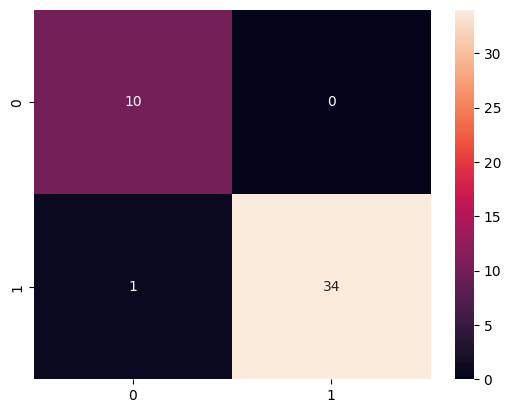

In [13]:
knn_classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, Y_train)
print(knn_classifier.score(X_test, Y_test)) 
y_pred = knn_classifier.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
print(sns.heatmap(cm, annot=True, fmt="d"))

### Applying __K-FOLD__ on the _data_ 

In [14]:
from sklearn.model_selection import cross_val_score
#K-Fold Cross Validation
accuracies = cross_val_score(estimator = knn_classifier, X = X_train, y = Y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))  #<-------------------mean
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))#<------------------std
accuracies

Accuracy: 98.00 %
Standard Deviation: 3.06 %


array([1.        , 1.        , 1.        , 0.93333333, 1.        ,
       1.        , 0.93333333, 0.93333333, 1.        , 1.        ])

#### Checking with __Grid Search__ the best parameters

In [15]:
#grid Search
parameters = {'n_neighbors': [ 2,3, 5, 7, 1, 9, 11, 13], 'metric': ['minkowski','manhattan','cosine'], 'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
grid_search = GridSearchCV(estimator = knn_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, Y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_#<-----------------------------the best
print("Best Parameters:", best_parameters)

Best Parameters: {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1}


### KNN after improvments

In [16]:
knn_classifier = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 1)
knn_classifier.fit(X_train, Y_train)
knn_score = knn_classifier.score(X_test, Y_test)
print(knn_score)
Y_pred = knn_classifier.predict(X_test)
print(Y_pred)

#cm = confusion_matrix(Y_test, Y_pred)
#print(sns.heatmap(cm, annot=True, fmt='d'))
print(knn_score)

knn_dict = {'model': knn_classifier, 'score': knn_score, "scaler":scaler}

1.0
[1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 0 1 1 1 1 1 1 1]
1.0


# SAVING TO MongoDB

In [17]:
def save_model_to_db(dict, client, db, dbconnection, model_name):
    import pickle
    import time
    import pymongo
    #pickling the model
    pickled_model = pickle.dumps(dict["model"])
    pickled_scaler = pickle.dumps(dict["scaler"])
    dict["model"]=pickled_model
    dict["scaler"]=pickled_scaler
    
    #saving model to mongoDB
    #creating connection
    myclient = pymongo.MongoClient(client)
    
    #creating database in mongodb
    mydb = myclient[db]
    
    #creating collection
    mycon = mydb[dbconnection]
    info = mycon.insert_one({model_name: pickled_model, 'name': model_name, 'created_time':time.time(),"score":dict["score"],"scaler":pickled_scaler})
    print(info.inserted_id, ' saved with this id successfully!')
    
    details = {
        'inserted_id':info.inserted_id,
        'model_name':model_name,
        'created_time':time.time()
    }
    return details

In [18]:
#saving knn model to mongoDB
save_model_to_db(knn_dict, 'mongodb://localhost:27017', 'Parkinson_Prediction', 'knn_model', 'first_model')

636cb96a1881e568162fd4bf  saved with this id successfully!


{'inserted_id': ObjectId('636cb96a1881e568162fd4bf'),
 'model_name': 'first_model',
 'created_time': 1668069738.727374}